# Import Packages

In [1]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [4]:
check.packages(c('RPostgreSQL', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot'))

RPostgreSQL     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE

In [5]:
options(scipen=999)

# Connect to Database

In [6]:
killDbConnections = function () {
  all_cons = dbListConnections(PostgreSQL())
  print(all_cons)
  for(con in all_cons)
    +  dbDisconnect(con)
  
#   print(paste(length(all_cons), " connections killed."))
}

In [7]:
createReportingConnectionObject = function() {
    
    killDbConnections()
    
    drv = dbDriver('PostgreSQL')

    reporting = dbConnect(
      drv,
      dbname = 'reporting',
      host = 'reporting.ckpglb17yttu.us-east-1.rds.amazonaws.com',
      port = 5432,
      user = Sys.getenv('REPORTING_USER'),
      password = Sys.getenv('REPORTING_PASS')
    )
}

In [8]:
checkReportingConnection = function() {
    
    print(paste(length(dbListConnections(PostgreSQL())), " connections active."))
}

In [9]:
# Do this once Lukass is back and I can set up my own schema that will have [bizops_application_details]

# dbGetQuery(createReportingConnectionObject(),
           
# '
# select
#     id
# from
#     cloudlending.applications
# order by
#     createddate desc
# limit 100
# '
# )

# Import Data

In [11]:
## For Monthly Comparison
# df = read.csv('C:/Users/jchang/Desktop/Projects/Automate FR Meetings/data/data_2019-1-8_2136.csv')

## For December YoY Comparison
# df = read.csv('C:/Users/jchang/Desktop/Projects/Automate FR Meetings/data/data_2019-1-9_1338.csv')




## For Previous 4 cohort
# df = read.csv('C:/Users/jchang/Desktop/Projects/Automate FR Meetings/data/datamatured_2019-1-21_0744.csv')

## For Previous 4 cohort (SNAPSHOT)
# df = read.csv('C:/Users/jchang/Desktop/Projects/Automate FR Meetings/data/databridgesnapshot_2019-1-21_1255.csv')

## For Previous 4 cohort (SNAPSHOT - 2 WITH HEAP)
# df = read.csv('C:/Users/jchang/Desktop/Projects/Automate FR Meetings/data/databridgesnapshotheap_2019-1-21_1421.csv')

## For Previous 1 cohort (SNAPSHOT - 2 WITH HEAP)
df = read.csv('C:/Users/jchang/Desktop/Projects/Automate FR Meetings/data/databridgesnapshotheap_2019-1-21_2012.csv')


head(df,5)

grouping,start_date,end_date,adgrp,qualified,attempt_ibv,bankverified,passscorecardratecard,contractsigned,cs_decisioned,funded
P1,2019-01-07,2019-01-13,Credit Karma,1257,905,868,567,495,400,301
P1,2019-01-07,2019-01-13,Credit Sesame,418,289,272,187,132,98,83
P1,2019-01-07,2019-01-13,Direct Mail,2868,1936,1855,1318,979,746,625
P1,2019-01-07,2019-01-13,Email,748,502,435,273,220,171,129
P1,2019-01-07,2019-01-13,Lead Providers,257,102,89,60,42,30,18


# Preprocessing Functions

##### Convert to Funnel Name

In [12]:
## THIS REQUIRES QUOTES AROUND THE ARGUMENT!

getFunnelName = function(atStatus_string) {
    
    return_string = ''
    
    if (atStatus_string == 'qualified') {
        return_string = 'Q'
    }
    else if (atStatus_string == 'attempt_ibv') {
        return_string = 'Attempt_IBV'
    }
    else if (atStatus_string == 'bankverified') {
        return_string = 'BV'
    }
    else if (atStatus_string == 'passscorecardratecard') {
        return_string = 'SC'
    }
    else if (atStatus_string == 'contractsigned') {
        return_string = 'CS'
    }
    else if (atStatus_string == 'cs_decisioned') {
        return_string = 'CS_Decisioned'
    }
    else if (atStatus_string == 'funded') {
        return_string = 'F'
    }
    
    return(return_string)
    
}

##### Get the Adgrp Mix [p(i)]

In [13]:
## We want to pass in a column name of df so that it gets summarized.
## However, there are two problems.
## When we call the function, the argument gets evaluated rather that quoted. We need it quoted.
## When the function is run, the argument gets automatically quoted. We want it done manually.
## So, we want to use quo() in the function call, then !! when the argument is referenced in the function.

In [14]:
## THIS REQUIRES QUO() IN THE ARGUMENT!
## This returns the denominator for each period.

getMixDenominator = function(denominator) {
    
    total = df %>%
        group_by(grouping) %>%
        summarize(total = sum(!!denominator))

    return(total)
}

In [15]:
## THIS REQUIRES QUO() IN THE ARGUMENT!
## This returns the period, adgrp, and mix at the status specified in the argument.

getMix = function(denominator) {
    
    
    ## First, calculate the total apps for each period.
    total = getMixDenominator(quo(!!denominator))
        
    
    ## Next, attach the denominator to the overall dataset, which is numerators.
    temp_df = merge(
        x = df,
        y = total,
        by.x = 'grouping',
        by.y = 'grouping'
    )
    
    
    ## Next, calculate the mix.
    mix = data.frame(
        temp_df[,'grouping'],
        temp_df[,'adgrp'],
        temp_df[,quo_name(denominator)]/temp_df[,'total']
    )
    
    
    ## Finally, format the data to be returned.
    colnames(mix) = c(
        'grouping',
        'adgrp',
        paste(getFunnelName(quo_name(denominator)),'_mix', sep = '')
    )
    
    mix$grouping = as.character(mix$grouping)
    mix$adgrp = as.character(mix$adgrp)
    
       
    return(mix)
    
}

##### Get the Adgrp Conversion Rate [y(i)]

In [16]:
## THIS REQUIRES QUOTES AROUND EACH ARGUMENT!
## This returns the period, adgrp, and conversion between the statuses specified in the argument.

getConversion = function(numerator, denominator){
    
    conversion = data.frame(
        df[,'grouping'],
        df[,'adgrp'],
        df[,quo_name(numerator)]/df[,quo_name(denominator)]
    )
           
    
    colnames(conversion) = c(
        'grouping',
        'adgrp',
        paste(getFunnelName(numerator),'_',getFunnelName(denominator),sep = '')
    )
    
    return(conversion)
    
}

##### Get the Total Conversion Rate [y_bar]

In [17]:
## THIS REQUIRES QUO() IN THE ARGUMENT!
## This returns the period, adgrp, and conversion between the statuses specified in the argument.

getConversionTotal = function(numerator, denominator){
    
    a = getMixDenominator(quo(!!numerator))
    b = getMixDenominator(quo(!!denominator))
    
    total_conversion = data.frame(
        a$grouping,
        'All',
        1,
        a$total/b$total
    )
    
    colnames(total_conversion) = c(
        'Grouping',
        'Adgrp',
        'Mix',
        paste(getFunnelName(quo_name(numerator)),'/',getFunnelName(quo_name(denominator)),sep = '')        
    )
    
    return(total_conversion)
    
}

##### Get Label Data Needed for ggplot Bridge

In [18]:
## THIS REQUIRES QUOTES AROUND EACH ARGUMENT!
## 

getLabels = function(numerator, denominator) {
    
    conversionName = ''

    if(quo_name(numerator) == 'funded' & quo_name(denominator) == 'qualified') {
        conversionName = 'Funding Rate'
    }
    else {
        conversionName = paste(
            getFunnelName(quo_name(numerator)),
            '/',
            getFunnelName(quo_name(denominator)),
            sep = ''
        )
    }
    
    
    p1_start = df$start_date[which(as.character(df$grouping) == 'P1')]
    p1_end = df$end_date[which(as.character(df$grouping) == 'P1')]
    p2_start = df$start_date[which(as.character(df$grouping) == 'P2')]
    p2_end = df$end_date[which(as.character(df$grouping) == 'P2')]
    
    all_labels = data.frame(
        conversionStep = conversionName,
        p1_start,
        p1_end,
        p2_start,
        p2_end
    )
        
    return(unique(all_labels))
    
}

##### Get Data Frame Needed for ggplot Bridge

In [19]:
## THIS REQUIRES QUO() IN THE ARGUMENT!
## This returns the period, adgrp, mix at the status specified in the argument, and the specified conversion.

getMixConversion = function(numerator, denominator) {

    mix = getMix(denominator = quo(!!denominator))
    conversion = getConversion(numerator = quo_name(numerator), denominator = quo_name(denominator))

    final_adgrp = merge(
        x = mix,
        y = conversion,
        by.x = c('grouping', 'adgrp'),
        by.y = c('grouping', 'adgrp')
    )

    final_all = getConversionTotal(numerator = quo(!!numerator), denominator = quo(!!denominator))
    
    colnames(final_all) = colnames (final_adgrp)

    final = rbind(final_adgrp, final_all)


    return(final)
    
}


In [20]:
getMixConversion(quo(bankverified), quo(qualified))

grouping,adgrp,Q_mix,BV_Q
P1,Credit Karma,0.099469811,0.6905330
P1,Credit Sesame,0.033077471,0.6507177
P1,Direct Mail,0.226952600,0.6467922
P1,Email,0.059191264,0.5815508
P1,Lead Providers,0.020337105,0.3463035
P1,Lending Tree,0.140618818,0.6235228
P1,New Initiatives,0.029516499,0.5871314
P1,Other,0.008071536,0.5882353
P1,Other Partners,0.181372161,0.5907504
P1,Referral,0.043918652,0.7837838


##### Reformat Data Frame Needed for ggplot Bridge

In [21]:
getMixConversionReformat = function(numerator, denominator) {
    
    preformat = getMixConversion(quo(!!numerator), quo(!!denominator))
    
    reformat = data.frame(
        adgrp = preformat$adgrp[which(preformat$grouping == 'P1')],
        p0 = preformat[,3][which(preformat$grouping == 'P1')],
        p1 = preformat[,3][which(preformat$grouping == 'P2')],
        y0 = preformat[,4][which(preformat$grouping == 'P1')],
        y1 = preformat[,4][which(preformat$grouping == 'P2')],
        ybar = preformat[,4][which(preformat$grouping == 'P1' & preformat$adgrp == 'All')]
        
    )
    
    return(reformat)
    
}

In [22]:
a = getMixConversionReformat(quo(bankverified), quo(qualified))
a

adgrp,p0,p1,y0,y1,ybar
Credit Karma,0.099469811,0.096577806,0.6905330,0.6695320,0.6329034
Credit Sesame,0.033077471,0.032100360,0.6507177,0.6149425,0.6329034
Direct Mail,0.226952600,0.224518033,0.6467922,0.6503698,0.6329034
Email,0.059191264,0.063278295,0.5815508,0.5655977,0.6329034
Lead Providers,0.020337105,0.004150909,0.3463035,0.5777778,0.6329034
Lending Tree,0.140618818,0.139101559,0.6235228,0.6392573,0.6329034
New Initiatives,0.029516499,0.027027027,0.5871314,0.5938567,0.6329034
Other,0.008071536,0.011714786,0.5882353,0.5669291,0.6329034
Other Partners,0.181372161,0.193063371,0.5907504,0.5800287,0.6329034
Referral,0.043918652,0.040125450,0.7837838,0.6689655,0.6329034


# Create ggplot Bridge

In [23]:
## One chart will have the the long bridge.
## One chart will have the deltas, split by color impact.
## One chart will have the deltas due to mix, another due to conversion.

In [24]:
## Run function to get necessary labels for the bridge.

df_labels = getLabels(quo(bankverified), quo(qualified))
df_labels

conversionStep,p1_start,p1_end,p2_start,p2_end
BV/Q,2019-01-07,2019-01-13,2019-01-14,2019-01-20


In [25]:
## Run function to get necessary parameters to build the bridge.

df_pull = getMixConversionReformat(quo(bankverified), quo(qualified))
df_pull

adgrp,p0,p1,y0,y1,ybar
Credit Karma,0.099469811,0.096577806,0.6905330,0.6695320,0.6329034
Credit Sesame,0.033077471,0.032100360,0.6507177,0.6149425,0.6329034
Direct Mail,0.226952600,0.224518033,0.6467922,0.6503698,0.6329034
Email,0.059191264,0.063278295,0.5815508,0.5655977,0.6329034
Lead Providers,0.020337105,0.004150909,0.3463035,0.5777778,0.6329034
Lending Tree,0.140618818,0.139101559,0.6235228,0.6392573,0.6329034
New Initiatives,0.029516499,0.027027027,0.5871314,0.5938567,0.6329034
Other,0.008071536,0.011714786,0.5882353,0.5669291,0.6329034
Other Partners,0.181372161,0.193063371,0.5907504,0.5800287,0.6329034
Referral,0.043918652,0.040125450,0.7837838,0.6689655,0.6329034


In [26]:
## First, calculate the mix and conversion impacts of each adgrp, and labeled as such.

df_bridge_mix = data.frame(
    type = rep('2Mix', nrow(df_pull)),
    adgrp = df_pull$adgrp,
    value = (df_pull$y0 - df_pull$ybar) * (df_pull$p1 - df_pull$p0)
)

df_bridge_conversion = data.frame(
    type = rep('4Conversion', nrow(df_pull)),
    adgrp = df_pull$adgrp,
    value = (df_pull$p1) * (df_pull$y1 - df_pull$y0)
)

df_bridge = rbind(
    df_bridge_mix,
    df_bridge_conversion
)


# df_bridge = data.frame(
#     type = c(rep('2Mix', nrow(df_pull)), rep('4Conversion', nrow(df_pull))),
#     adgrp = rep(df_pull$adgrp, 2),
#     value = c(df_pull$y0 * (df_pull$p1-df_pull$p0),df_pull$p1 * (df_pull$y1-df_pull$y0))
# )

df_bridge = df_bridge[which(df_bridge$adgrp != 'All'),]

df_bridge$adgrp = paste(substr(df_bridge$type,1,1), df_bridge$adgrp, sep = '')

# df_bridge$adgrp = ifelse(
#     as.numeric(substr(df_bridge$type,1,1)) == 2,
#     paste('Mix_', df_bridge$adgrp, sep = ''),
#     paste('Conversion_', df_bridge$adgrp, sep = '')
# )

df_bridge

,type,adgrp,value
1,2Mix,2Credit Karma,-0.000166665161
2,2Mix,2Credit Sesame,-0.000017406575
3,2Mix,2Direct Mail,-0.000033813228
4,2Mix,2Email,-0.000209879605
5,2Mix,2Lead Providers,0.004638961995
6,2Mix,2Lending Tree,0.000014232780
7,2Mix,2New Initiatives,0.000113948148
8,2Mix,2Other,-0.000162737022
9,2Mix,2Other Partners,-0.000492818881
10,2Mix,2Referral,-0.000572319838


In [27]:
## Second, calculate the Previous, Mix Checkpoint, and Current conversion rates.

df_all = data.frame(
    type = c('1Previous','3PostMix','5Current'),
    adgrp = c('Previous','PostMix','Current'),
#     adgrp = rep('All',3),
    value = c(df_pull$y0[which(df_pull$adgrp == 'All')],
              df_pull$y0[which(df_pull$adgrp == 'All')] + sum(df_bridge$value[which(df_bridge$type == '2Mix')]),
              df_pull$y1[which(df_pull$adgrp == 'All')]                 
             )
)
df_all$adgrp = paste(substr(df_all$type,1,1), df_all$adgrp, sep = '')

df_all

type,adgrp,value
1Previous,1Previous,0.6329034
3PostMix,3PostMix,0.6362526
5Current,5Current,0.6292777


In [28]:
## Third, combine the two above data frames, and assign a color.

df_bridge_combined = rbind(
    df_bridge,
    df_all
)

df_bridge_combined = data.frame(
    df_bridge_combined,
#     color = rep('colored', nrow(df_bridge_combined))
    color = ifelse(
        as.numeric(substr(df_bridge_combined$type,1,1)) %in% c(1,3,5),
        'blue',
        ifelse(
            df_bridge_combined$value >= 0,
            'green',
            'red'
        )
    )
)

df_bridge_combined$type = as.character(df_bridge_combined$type)
df_bridge_combined$adgrp = as.character(df_bridge_combined$adgrp)

df_bridge_combined

,type,adgrp,value,color
1,2Mix,2Credit Karma,-0.000166665161,red
2,2Mix,2Credit Sesame,-0.000017406575,red
3,2Mix,2Direct Mail,-0.000033813228,red
4,2Mix,2Email,-0.000209879605,red
5,2Mix,2Lead Providers,0.004638961995,green
6,2Mix,2Lending Tree,0.000014232780,green
7,2Mix,2New Initiatives,0.000113948148,green
8,2Mix,2Other,-0.000162737022,red
9,2Mix,2Other Partners,-0.000492818881,red
10,2Mix,2Referral,-0.000572319838,red


In [29]:
## Fourth, sort the Mix and Conversion impacts in descending order.

df_sorted = rbind(
    df_bridge_combined[which(df_bridge_combined$type == '1Previous'),],
df_bridge_combined[which(df_bridge_combined$type == '2Mix'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '2Mix')])),],
    df_bridge_combined[which(df_bridge_combined$type == '3PostMix'),],
    df_bridge_combined[which(df_bridge_combined$type == '4Conversion'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '4Conversion')])),],
    df_bridge_combined[which(df_bridge_combined$type == '5Current'),]
)
rownames(df_sorted) = seq(1:nrow(df_sorted))

df_sorted

type,adgrp,value,color
1Previous,1Previous,0.632903378967,blue
2Mix,2Lead Providers,0.004638961995,green
2Mix,2SEO,0.000237695484,green
2Mix,2New Initiatives,0.000113948148,green
2Mix,2Lending Tree,0.000014232780,green
2Mix,2Credit Sesame,-0.000017406575,red
2Mix,2Direct Mail,-0.000033813228,red
2Mix,2Other,-0.000162737022,red
2Mix,2Credit Karma,-0.000166665161,red
2Mix,2Email,-0.000209879605,red


In [30]:
## Fifth, calculate the whitespace that must pad the bridge values.

white = c(
    0,
    df_sorted$value[which(df_sorted$type == '1Previous')] + 
        cumsum(df_sorted$value[which(df_sorted$type == '2Mix')]) -
        ifelse(df_sorted$value[which(df_sorted$type == '2Mix')] > 0,
               df_sorted$value[which(df_sorted$type == '2Mix')],
               0),
    0,
    df_sorted$value[which(df_sorted$type == '3PostMix')] + 
        cumsum(df_sorted$value[which(df_sorted$type == '4Conversion')]) -
        ifelse(df_sorted$value[which(df_sorted$type == '4Conversion')] > 0,
               df_sorted$value[which(df_sorted$type == '4Conversion')],
               0),
    0
)

df_whitespace = data.frame(
    type = df_sorted$type,
    adgrp = df_sorted$adgrp,
    value = white,
    color = rep('white', nrow(df_sorted))
)

df_whitespace

type,adgrp,value,color
1Previous,1Previous,0.0000000,white
2Mix,2Lead Providers,0.6329034,white
2Mix,2SEO,0.6375423,white
2Mix,2New Initiatives,0.6377800,white
2Mix,2Lending Tree,0.6378940,white
2Mix,2Credit Sesame,0.6378908,white
2Mix,2Direct Mail,0.6378570,white
2Mix,2Other,0.6376943,white
2Mix,2Credit Karma,0.6375276,white
2Mix,2Email,0.6373177,white


In [31]:
## Finally, append the two data frames.
## We need to convert the x axis (adgrps) back to factors from strings in order to preserve the sort order we want.
## Since df_dinal$adgrp is non-unique, we must pass a vector with no duplicate values as part of this process.

## Value must be reformatted into Value_label and Value_bar.
## This is to ensure that the white space is below the colored portion, while allowing accurate data labels.

df_appended = rbind(
    df_sorted,
    df_whitespace
)

df_appended$adgrp = factor(df_appended$adgrp, levels = unique(df_appended$adgrp))

# df_appended

df_final = data.frame(
    df_appended,
    value_bar = abs(df_appended$value),
    value_label = ifelse(
        as.character(df_appended$color) != 'white',
        ifelse(
            as.numeric(substr(df_appended$type,1,1)) %in% c(1,3,5),
            paste(round(df_appended$value*100,2), '%', sep = ''),
            paste(round(df_appended$value*10000,0))
        ),
        ''
    )
)

df_final

type,adgrp,value,color,value_bar,value_label
1Previous,1Previous,0.632903378967,blue,0.632903378967,63.29%
2Mix,2Lead Providers,0.004638961995,green,0.004638961995,46
2Mix,2SEO,0.000237695484,green,0.000237695484,2
2Mix,2New Initiatives,0.000113948148,green,0.000113948148,1
2Mix,2Lending Tree,0.000014232780,green,0.000014232780,0
2Mix,2Credit Sesame,-0.000017406575,red,0.000017406575,0
2Mix,2Direct Mail,-0.000033813228,red,0.000033813228,0
2Mix,2Other,-0.000162737022,red,0.000162737022,-2
2Mix,2Credit Karma,-0.000166665161,red,0.000166665161,-2
2Mix,2Email,-0.000209879605,red,0.000209879605,-2


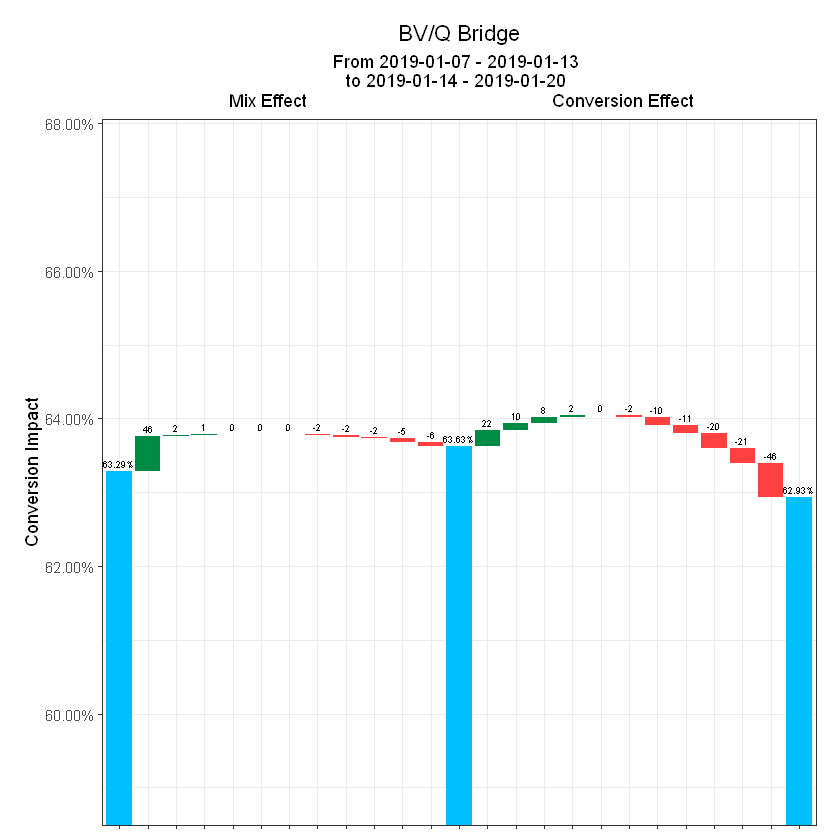

In [32]:
###### Finally, create the bridge.
## First, set the theme.
## Second, call ggplot(). We pass in value_bar, which are all positive values, to ensure that white bars stay on bottom.
## Color will control fill and transparency (alpha).

theme_set(theme_bw())

gg_bridge =

ggplot(
    data = df_final,
    mapping = aes(
        x = adgrp,
        y = value_bar,
        fill = color,
        alpha = color
    )
) +
geom_col() +
scale_fill_manual(
    'legend',
    values = c(
        'red' = 'brown1',
        'green' = 'springgreen4',
        'blue' = 'deepskyblue',
        'white' = 'white'
    )
) +
scale_alpha_manual(
    values = c(
        'blue' = 1,
        'green' = 1,
        'red' = 1,
        'white' = 0
    )
) +
scale_y_continuous(
    labels = scales::percent
#     limits = c(min(df_final$value[which(substr(df_final$type,1,1) %in% c(1,3,5) & as.character(df_final$color) != 'white')]) - 0.04,NA)
) +
coord_cartesian(
    ylim = c(
        min(df_final$value[which(substr(df_final$type,1,1) %in% c(1,3,5) & as.character(df_final$color) != 'white')]) - 0.04,
        max(df_final$value[which(substr(df_final$type,1,1) %in% c(1,3,5) & as.character(df_final$color) != 'white')]) + 0.04
    )
) +
geom_text(
    aes(label = value_label),
    position = 'stack',
    vjust = -0.5,
    hjust = 0.5,
    size = 2
) +
labs(
    x = '',
    y = 'Conversion Impact',
    title = paste(df_labels$conversionStep, 'Bridge'),
    subtitle = paste(
        'From',
        df_labels$p1_start, '-', df_labels$p1_end,
        '\nto',
        df_labels$p2_start, '-', df_labels$p2_end,
        '\n Mix Effect                                                 Conversion Effect'
    )
) +
theme(
    plot.title = element_text(
        hjust = 0.5
    ),
    plot.subtitle = element_text(
        hjust = 0.5
    ),
    axis.title.x = element_text(
        hjust = 0.5
    ),
    axis.text.x = element_blank(),
#     axis.text.x = element_text(
#         angle = 270,
#         size = 8,
#         vjust = 0.25,
#         hjust = 0
#     ),
    plot.margin = unit(c(0.5,0.5,-0.25,0.5), 'cm'),
    legend.position = "none"
#     , aspect.ratio = 4/6
)

gg_bridge


# Create ggplot deltas

In [33]:
## Run function to get necessary labels for the bridge.

df_labels = getLabels(quo(bankverified), quo(qualified))
df_labels

conversionStep,p1_start,p1_end,p2_start,p2_end
BV/Q,2019-01-07,2019-01-13,2019-01-14,2019-01-20


In [34]:
## Run function to get necessary parameters to build the bridge.

df_pull_deltas = getMixConversionReformat(quo(bankverified), quo(qualified))
# df_pull = df_pull[which(df_pull$adgrp != 'All'),]

df_pull_deltas

adgrp,p0,p1,y0,y1,ybar
Credit Karma,0.099469811,0.096577806,0.6905330,0.6695320,0.6329034
Credit Sesame,0.033077471,0.032100360,0.6507177,0.6149425,0.6329034
Direct Mail,0.226952600,0.224518033,0.6467922,0.6503698,0.6329034
Email,0.059191264,0.063278295,0.5815508,0.5655977,0.6329034
Lead Providers,0.020337105,0.004150909,0.3463035,0.5777778,0.6329034
Lending Tree,0.140618818,0.139101559,0.6235228,0.6392573,0.6329034
New Initiatives,0.029516499,0.027027027,0.5871314,0.5938567,0.6329034
Other,0.008071536,0.011714786,0.5882353,0.5669291,0.6329034
Other Partners,0.181372161,0.193063371,0.5907504,0.5800287,0.6329034
Referral,0.043918652,0.040125450,0.7837838,0.6689655,0.6329034


In [35]:
## Calculate the deltas and format in long view.

df_deltas_mix = data.frame(
    adgrp = paste('2', df_pull_deltas$adgrp, sep = ''),
    delta = round(10000*(df_pull_deltas$p1 - df_pull_deltas$p0),0)
)

df_deltas_conversion = data.frame(
    adgrp = paste('4', df_pull_deltas$adgrp, sep = ''),
    delta = round(10000*(df_pull_deltas$y1 - df_pull_deltas$y0),0)
)

df_deltas_appended = rbind(
    df_deltas_mix[which(df_deltas_mix$adgrp != '2All'),],
    df_deltas_conversion[which(df_deltas_conversion$adgrp != '4All'),]   
)
df_deltas_appended

adgrp,delta
2Credit Karma,-29
2Credit Sesame,-10
2Direct Mail,-24
2Email,41
2Lead Providers,-162
2Lending Tree,-15
2New Initiatives,-25
2Other,36
2Other Partners,117
2Referral,-38


In [36]:
## Create the placeholders for the conversion checkpoints.

df_deltas_placeholders = data.frame(
    adgrp = c('1Previous','3PostMix','5Current'),
#     delta = rep(0, times = 3)
    delta = c(0,
              round(10000*(sum(df_final$value[which(df_final$type == '2Mix' & df_final$color != 'white')])),0),
              round(10000*(df_pull_deltas$y1[which(df_pull_deltas$adgrp == 'All')] - (df_pull_deltas$y0[which(df_pull_deltas$adgrp == 'All')] + sum(df_final$value[which(df_final$type == '2Mix' & df_final$color != 'white')]))),0)
    )
)
df_deltas_placeholders

adgrp,delta
1Previous,0
3PostMix,33
5Current,-70


In [37]:
## Append the placeholders to the deltas. Make sure that these are in the same pre-sorted order as above! (df_bridge_combined)

df_deltas_combined = rbind(
    df_deltas_appended,
    df_deltas_placeholders
)

df_deltas_combined

adgrp,delta
2Credit Karma,-29
2Credit Sesame,-10
2Direct Mail,-24
2Email,41
2Lead Providers,-162
2Lending Tree,-15
2New Initiatives,-25
2Other,36
2Other Partners,117
2Referral,-38


In [38]:
## Assign a color based on the value.

df_deltas = data.frame(
    df_deltas_combined,
    color = ifelse(
        as.numeric(substr(df_deltas_combined$adgrp,1,1)) %in% c(1,3,5),
        'blue',
        ifelse(df_deltas_combined$delta >= 0, 'green', 'red')
    )   
)
df_deltas

adgrp,delta,color
2Credit Karma,-29,red
2Credit Sesame,-10,red
2Direct Mail,-24,red
2Email,41,green
2Lead Providers,-162,red
2Lending Tree,-15,red
2New Initiatives,-25,red
2Other,36,green
2Other Partners,117,green
2Referral,-38,red


In [39]:
## Sort the deltas values in the same order as the final bridge data.
## Ensure that ggplot follows this sorting by setting the factor levels.

df_deltas_final = rbind(
    df_deltas[which(df_deltas$adgrp == '1Previous'),],
    df_deltas[which(substr(df_deltas$adgrp,1,1) == '2'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '2Mix')])),],
    df_deltas[which(df_deltas$adgrp == '3PostMix'),],
    df_deltas[which(substr(df_deltas$adgrp,1,1) == '4'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '4Conversion')])),],
    df_deltas[which(df_deltas$adgrp == '5Current'),]

)
df_deltas_final$adgrp = factor(df_deltas_final$adgrp, levels = unique(df_deltas_final$adgrp))

df_deltas_final




,adgrp,delta,color
23,1Previous,0,blue
5,2Lead Providers,-162,red
11,2SEO,109,green
7,2New Initiatives,-25,red
6,2Lending Tree,-15,red
2,2Credit Sesame,-10,red
3,2Direct Mail,-24,red
8,2Other,36,green
1,2Credit Karma,-29,red
4,2Email,41,green


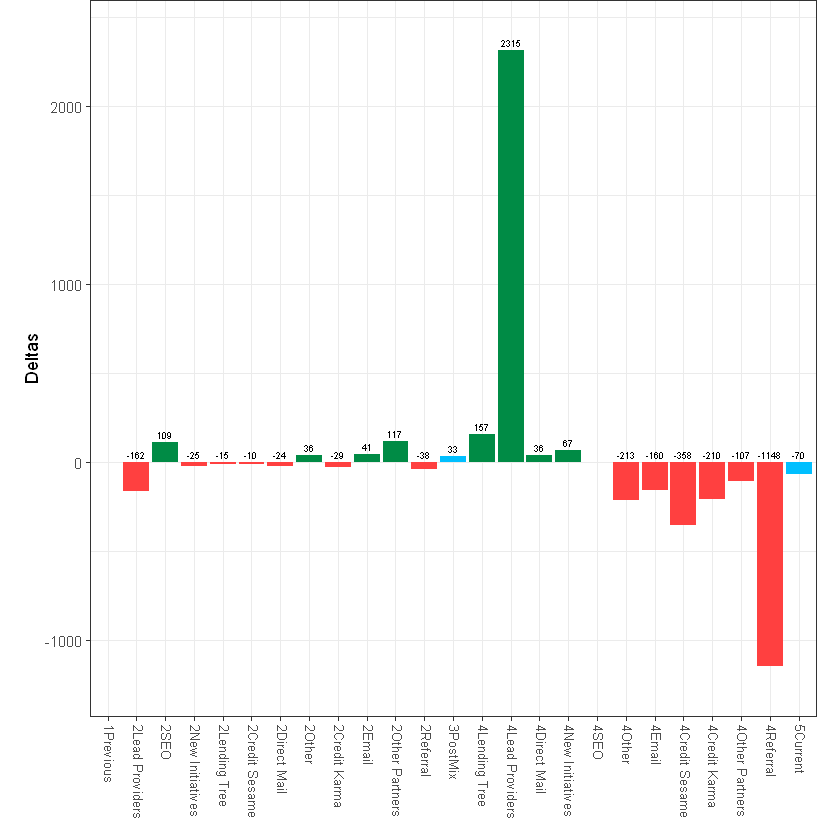

In [40]:
## Create the deltas.


gg_deltas = 

ggplot(
    data = df_deltas_final,
    mapping = aes(
        x = adgrp,
        y = delta,
        fill = color
    )
) + 
geom_col() +
scale_fill_manual(
    'legend',
    values = c(
        'red' = 'brown1',
        'green' = 'springgreen4',
        'blue' = 'deepskyblue'
    )
) + 
coord_cartesian(
    ylim = c(
        min(df_deltas_final$delta) - 100,
        max(df_deltas_final$delta) + 100
    )
) +
geom_text(
    data = subset(df_deltas_final, delta != 0),
    aes(label = delta),
    position = 'stack',
    vjust = -0.5,
    hjust = 0.5,
    size = 2
) +
labs(
    x = '',
    y = 'Deltas'
) +
theme(
    axis.title.x = element_text(
        hjust = 0.5
    ),
    axis.text.x = element_text(
        angle = 270,
        size = 8,
        vjust = 0.25,
        hjust = 0
    ),
    plot.margin = unit(c(0,0.5,0,0.5), 'cm'),
#     panel.border = element_blank(),
    legend.position = "none"
#     , aspect.ratio = 1/6
)

gg_deltas

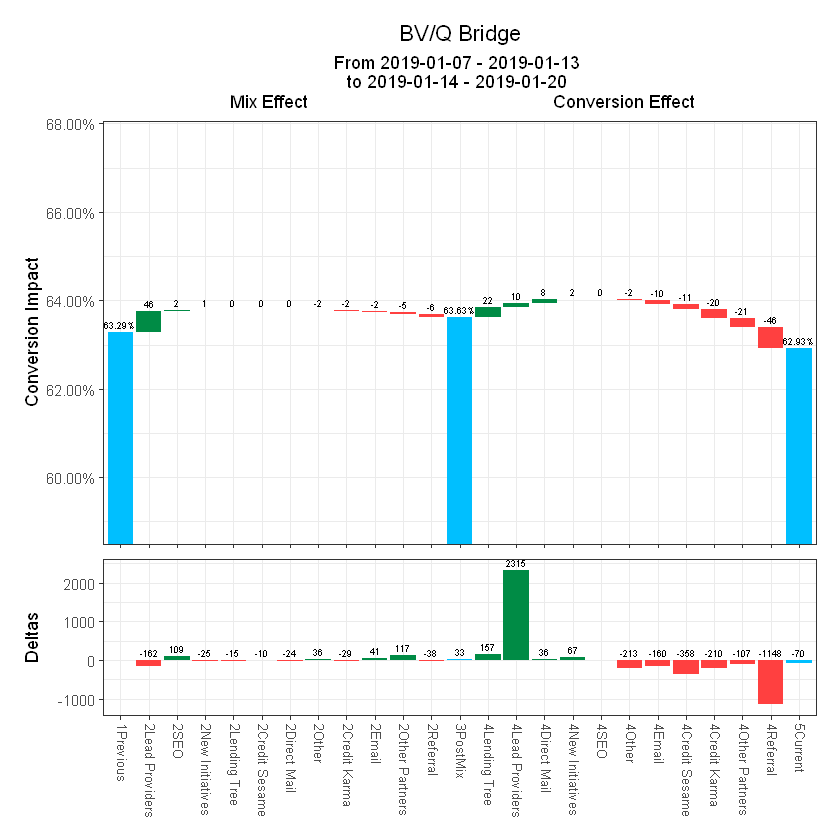

In [42]:
gg_stacked = 

plot_grid(
    gg_bridge,
    gg_deltas,
    align = 'v',
    nrow = 2,
    rel_heights = c(2/3, 1/3)
)

gg_stacked

# Convert the above into a function.


In [43]:
get_ggplot = function(numerator, denominator) {

    ## Run function to get necessary labels for the bridge.

    df_labels = getLabels(quo(!!numerator), quo(!!denominator))
    df_labels

    ## Run function to get necessary parameters to build the bridge.

    df_pull = getMixConversionReformat(quo(!!numerator), quo(!!denominator))
    df_pull
    

    ## First, calculate the mix and conversion impacts of each adgrp, and labeled as such.

    df_bridge_mix = data.frame(
        type = rep('2Mix', nrow(df_pull)),
        adgrp = df_pull$adgrp,
        value = (df_pull$y0 - df_pull$ybar) * (df_pull$p1 - df_pull$p0)
    )

    df_bridge_conversion = data.frame(
        type = rep('4Conversion', nrow(df_pull)),
        adgrp = df_pull$adgrp,
        value = (df_pull$p1) * (df_pull$y1 - df_pull$y0)
    )

    df_bridge = rbind(
        df_bridge_mix,
        df_bridge_conversion
    )


    # df_bridge = data.frame(
    #     type = c(rep('2Mix', nrow(df_pull)), rep('4Conversion', nrow(df_pull))),
    #     adgrp = rep(df_pull$adgrp, 2),
    #     value = c(df_pull$y0 * (df_pull$p1-df_pull$p0),df_pull$p1 * (df_pull$y1-df_pull$y0))
    # )

    df_bridge = df_bridge[which(df_bridge$adgrp != 'All'),]

    df_bridge$adgrp = paste(substr(df_bridge$type,1,1), df_bridge$adgrp, sep = '')

    # df_bridge$adgrp = ifelse(
    #     as.numeric(substr(df_bridge$type,1,1)) == 2,
    #     paste('Mix_', df_bridge$adgrp, sep = ''),
    #     paste('Conversion_', df_bridge$adgrp, sep = '')
    # )


    ## Second, calculate the Previous, Mix Checkpoint, and Current conversion rates.

    df_all = data.frame(
        type = c('1Previous','3PostMix','5Current'),
        adgrp = c('Previous','PostMix','Current'),
    #     adgrp = rep('All',3),
        value = c(df_pull$y0[which(df_pull$adgrp == 'All')],
                  df_pull$y0[which(df_pull$adgrp == 'All')] + sum(df_bridge$value[which(df_bridge$type == '2Mix')]),
                  df_pull$y1[which(df_pull$adgrp == 'All')]                 
                 )
    )
    df_all$adgrp = paste(substr(df_all$type,1,1), df_all$adgrp, sep = '')


    ## Third, combine the two above data frames, and assign a color.

    df_bridge_combined = rbind(
        df_bridge,
        df_all
    )

    df_bridge_combined = data.frame(
        df_bridge_combined,
    #     color = rep('colored', nrow(df_bridge_combined))
        color = ifelse(
            as.numeric(substr(df_bridge_combined$type,1,1)) %in% c(1,3,5),
            'blue',
            ifelse(
                df_bridge_combined$value >= 0,
                'green',
                'red'
            )
        )
    )

    df_bridge_combined$type = as.character(df_bridge_combined$type)
    df_bridge_combined$adgrp = as.character(df_bridge_combined$adgrp)


    ## Fourth, sort the Mix and Conversion impacts in descending order.

    df_sorted = rbind(
        df_bridge_combined[which(df_bridge_combined$type == '1Previous'),],
    df_bridge_combined[which(df_bridge_combined$type == '2Mix'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '2Mix')])),],
        df_bridge_combined[which(df_bridge_combined$type == '3PostMix'),],
        df_bridge_combined[which(df_bridge_combined$type == '4Conversion'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '4Conversion')])),],
        df_bridge_combined[which(df_bridge_combined$type == '5Current'),]
    )
    rownames(df_sorted) = seq(1:nrow(df_sorted))

    ## Fifth, calculate the whitespace that must pad the bridge values.

    white = c(
        0,
        df_sorted$value[which(df_sorted$type == '1Previous')] + 
            cumsum(df_sorted$value[which(df_sorted$type == '2Mix')]) -
            ifelse(df_sorted$value[which(df_sorted$type == '2Mix')] > 0,
                   df_sorted$value[which(df_sorted$type == '2Mix')],
                   0),
        0,
        df_sorted$value[which(df_sorted$type == '3PostMix')] + 
            cumsum(df_sorted$value[which(df_sorted$type == '4Conversion')]) -
            ifelse(df_sorted$value[which(df_sorted$type == '4Conversion')] > 0,
                   df_sorted$value[which(df_sorted$type == '4Conversion')],
                   0),
        0
    )

    df_whitespace = data.frame(
        type = df_sorted$type,
        adgrp = df_sorted$adgrp,
        value = white,
        color = rep('white', nrow(df_sorted))
    )


    ## Finally, append the two data frames.
    ## We need to convert the x axis (adgrps) back to factors from strings in order to preserve the sort order we want.
    ## Since df_dinal$adgrp is non-unique, we must pass a vector with no duplicate values as part of this process.

    ## Value must be reformatted into Value_label and Value_bar.
    ## This is to ensure that the white space is below the colored portion, while allowing accurate data labels.

    df_appended = rbind(
        df_sorted,
        df_whitespace
    )

    df_appended$adgrp = factor(df_appended$adgrp, levels = unique(df_appended$adgrp))

    # df_appended

    df_final = data.frame(
        df_appended,
        value_bar = abs(df_appended$value),
        value_label = ifelse(
            as.character(df_appended$color) != 'white',
            ifelse(
                as.numeric(substr(df_appended$type,1,1)) %in% c(1,3,5),
                paste(round(df_appended$value*100,2), '%', sep = ''),
                paste(round(df_appended$value*10000,0))
            ),
            ''
        )
    )




    ###### Finally, create the bridge.
    ## First, set the theme.
    ## Second, call ggplot(). We pass in value_bar, which are all positive values, to ensure that white bars stay on bottom.
    ## Color will control fill and transparency (alpha).

    theme_set(theme_bw())

    gg_bridge =

    ggplot(
        data = df_final,
        mapping = aes(
            x = adgrp,
            y = value_bar,
            fill = color,
            alpha = color
        )
    ) +
    geom_col() +
    scale_fill_manual(
        'legend',
        values = c(
            'red' = 'brown1',
            'green' = 'springgreen4',
            'blue' = 'deepskyblue',
            'white' = 'white'
        )
    ) +
    scale_alpha_manual(
        values = c(
            'blue' = 1,
            'green' = 1,
            'red' = 1,
            'white' = 0
        )
    ) +
    scale_y_continuous(
        labels = scales::percent
    #     limits = c(min(df_final$value[which(substr(df_final$type,1,1) %in% c(1,3,5) & as.character(df_final$color) != 'white')]) - 0.04,NA)
    ) +
    coord_cartesian(
        ylim = c(
            min(df_final$value[which(substr(df_final$type,1,1) %in% c(1,3,5) & as.character(df_final$color) != 'white')]) - 0.04,
            max(df_final$value[which(substr(df_final$type,1,1) %in% c(1,3,5) & as.character(df_final$color) != 'white')]) + 0.04
        )
    ) +
    geom_text(
        aes(label = value_label),
        position = 'stack',
        vjust = -0.5,
        hjust = 0.5,
        size = 2
    ) +
    labs(
        x = '',
        y = 'Conversion Impact',
        title = paste(df_labels$conversionStep, 'Bridge'),
        subtitle = paste(
            'From',
            df_labels$p1_start, '-', df_labels$p1_end,
            '\nto',
            df_labels$p2_start, '-', df_labels$p2_end,
            '\n Mix                                                        Conversion'
        )
    ) +
    theme(
        plot.title = element_text(
            hjust = 0.5
        ),
        plot.subtitle = element_text(
            hjust = 0.5
        ),
        axis.title.x = element_text(
            hjust = 0.5
        ),
        axis.text.x = element_blank(),
    #     axis.text.x = element_text(
    #         angle = 270,
    #         size = 8,
    #         vjust = 0.25,
    #         hjust = 0
    #     ),
        plot.margin = unit(c(0.5,0.5,-0.25,0.5), 'cm'),
        legend.position = "none"
#         , aspect.ratio = 4/6
    )


    ## Calculate the deltas and format in long view.

    
    df_pull_deltas = getMixConversionReformat(quo(!!numerator), quo(!!denominator))
    
    df_deltas_mix = data.frame(
        adgrp = paste('2', df_pull_deltas$adgrp, sep = ''),
        delta = round(10000*(df_pull_deltas$p1 - df_pull_deltas$p0),0)
    )

    df_deltas_conversion = data.frame(
        adgrp = paste('4', df_pull_deltas$adgrp, sep = ''),
        delta = round(10000*(df_pull_deltas$y1 - df_pull_deltas$y0),0)
    )

    df_deltas_appended = rbind(
        df_deltas_mix[which(df_deltas_mix$adgrp != '2All'),],
        df_deltas_conversion[which(df_deltas_conversion$adgrp != '4All'),]   
    )

    ## Create the placeholders for the conversion checkpoints.

    df_deltas_placeholders = data.frame(
        adgrp = c('1Previous','3PostMix','5Current'),
    #     delta = rep(0, times = 3)
        delta = c(0,
                  round(10000*(sum(df_final$value[which(df_final$type == '2Mix' & df_final$color != 'white')])),0),
                  round(10000*(df_pull_deltas$y1[which(df_pull_deltas$adgrp == 'All')] - (df_pull_deltas$y0[which(df_pull_deltas$adgrp == 'All')] + sum(df_final$value[which(df_final$type == '2Mix' & df_final$color != 'white')]))),0)
        )
    )

    ## Append the placeholders to the deltas. Make sure that these are in the same pre-sorted order as above! (df_bridge_combined)

    df_deltas_combined = rbind(
        df_deltas_appended,
        df_deltas_placeholders
    )


    ## Assign a color based on the value.

    df_deltas = data.frame(
        df_deltas_combined,
        color = ifelse(
            as.numeric(substr(df_deltas_combined$adgrp,1,1)) %in% c(1,3,5),
            'blue',
            ifelse(df_deltas_combined$delta >= 0, 'green', 'red')
        )   
    )

    ## Sort the deltas values in the same order as the final bridge data.
    ## Ensure that ggplot follows this sorting by setting the factor levels.

    df_deltas_final = rbind(
        df_deltas[which(df_deltas$adgrp == '1Previous'),],
        df_deltas[which(substr(df_deltas$adgrp,1,1) == '2'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '2Mix')])),],
        df_deltas[which(df_deltas$adgrp == '3PostMix'),],
        df_deltas[which(substr(df_deltas$adgrp,1,1) == '4'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '4Conversion')])),],
        df_deltas[which(df_deltas$adgrp == '5Current'),]

    )
    df_deltas_final$adgrp = factor(df_deltas_final$adgrp, levels = unique(df_deltas_final$adgrp))





    ## Create the deltas.


    gg_deltas = 

    ggplot(
        data = df_deltas_final,
        mapping = aes(
            x = adgrp,
            y = delta,
            fill = color
        )
    ) + 
    geom_col() +
    scale_fill_manual(
        'legend',
        values = c(
            'red' = 'brown1',
            'green' = 'springgreen4',
            'blue' = 'deepskyblue'
        )
    ) + 
    coord_cartesian(
        ylim = c(
            min(df_deltas_final$delta) - 100,
            max(df_deltas_final$delta) + 100
        )
    ) +
    geom_text(
        data = subset(df_deltas_final, delta != 0),
        aes(label = delta),
        position = 'stack',
        vjust = -0.5,
        hjust = 0.5,
        size = 2
    ) +
    labs(
        x = '',
        y = 'Deltas'
    ) +
    theme(
        axis.title.x = element_text(
            hjust = 0.5
        ),
        axis.text.x = element_text(
            angle = 270,
            size = 8,
            vjust = 0.25,
            hjust = 0
        ),
        plot.margin = unit(c(0,0.5,0,0.5), 'cm'),
    #     panel.border = element_blank(),
        legend.position = "none"
#         , aspect.ratio = 1/6
    )


    gg_stacked = 

    plot_grid(
        gg_bridge,
        gg_deltas,
        align = 'v',
        nrow = 2,
        rel_heights = c(2/3, 1/3)
    )

    return(gg_stacked)
}

In [44]:
get_ggplot_all = function(snapshot = FALSE) {
    
    
    ## snapshot == TRUE omits the attempt_ibv conversion step, due to irregular refreshing intervals.
    
    if(snapshot == FALSE) {
        
        all_plots = list(
        
            get_ggplot(numerator = quo(funded), denominator = quo(qualified)),
            get_ggplot(numerator = quo(attempt_ibv), denominator = quo(qualified)),
            get_ggplot(numerator = quo(bankverified), denominator = quo(attempt_ibv)),
            get_ggplot(numerator = quo(passscorecardratecard), denominator = quo(bankverified)),
            get_ggplot(numerator = quo(contractsigned), denominator = quo(passscorecardratecard)),
            get_ggplot(numerator = quo(cs_decisioned), denominator = quo(contractsigned)),
            get_ggplot(numerator = quo(funded), denominator = quo(cs_decisioned))
    
        )
        
    }
    else if(snapshot == TRUE) {
        
        all_plots = list(
        
            get_ggplot(numerator = quo(funded), denominator = quo(qualified)),
            get_ggplot(numerator = quo(bankverified), denominator = quo(qualified)),
            get_ggplot(numerator = quo(passscorecardratecard), denominator = quo(bankverified)),
            get_ggplot(numerator = quo(contractsigned), denominator = quo(passscorecardratecard)),
            get_ggplot(numerator = quo(cs_decisioned), denominator = quo(contractsigned)),
            get_ggplot(numerator = quo(funded), denominator = quo(cs_decisioned))
    
        )
        
    }
    
    return(all_plots)
    
}

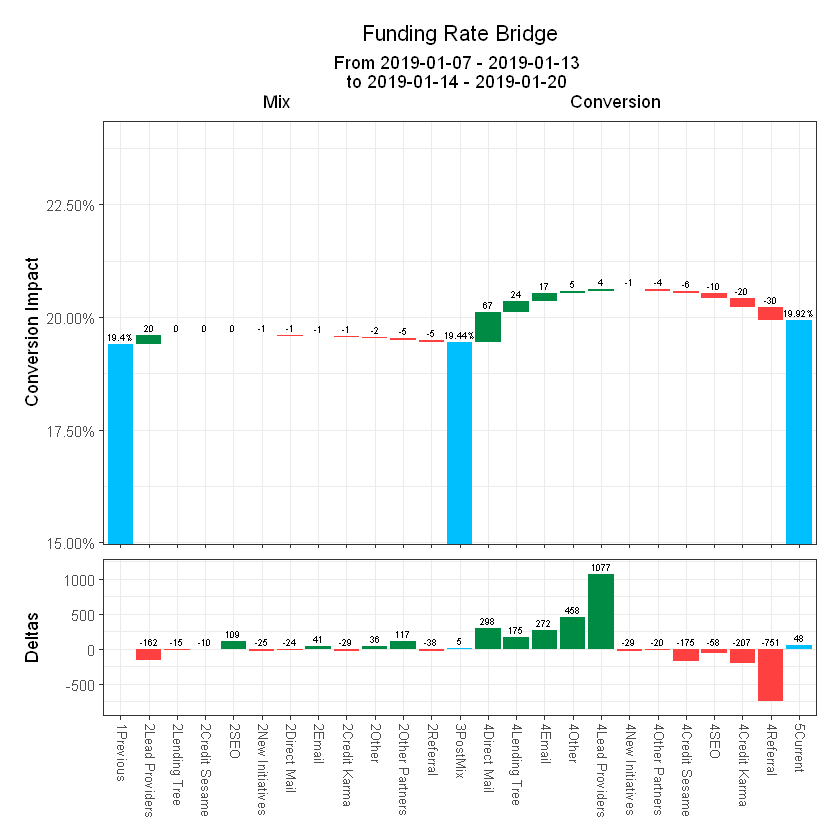

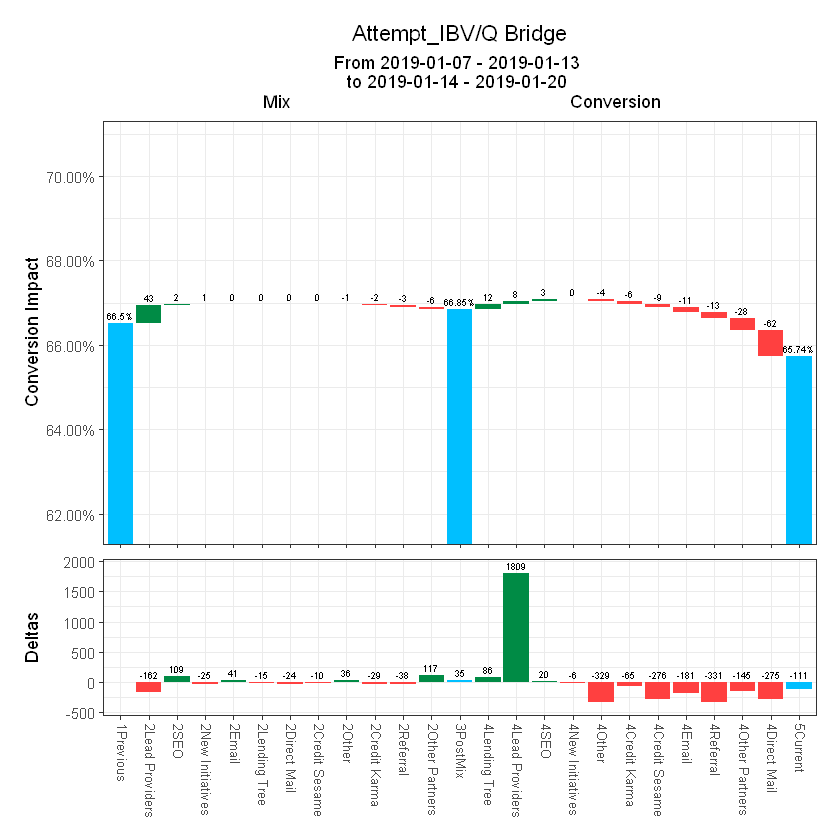

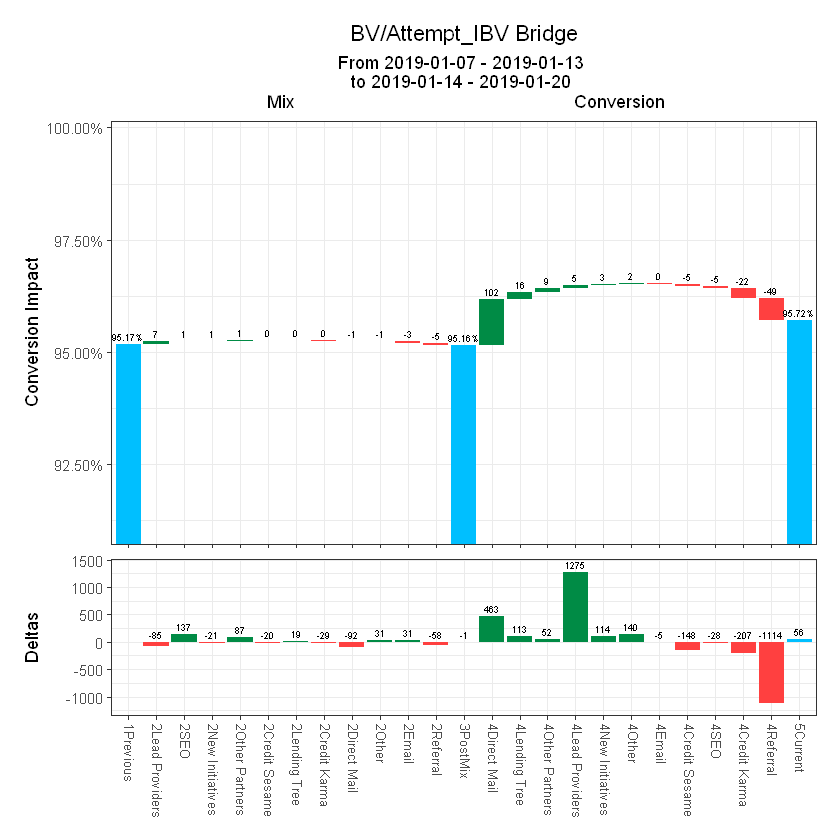

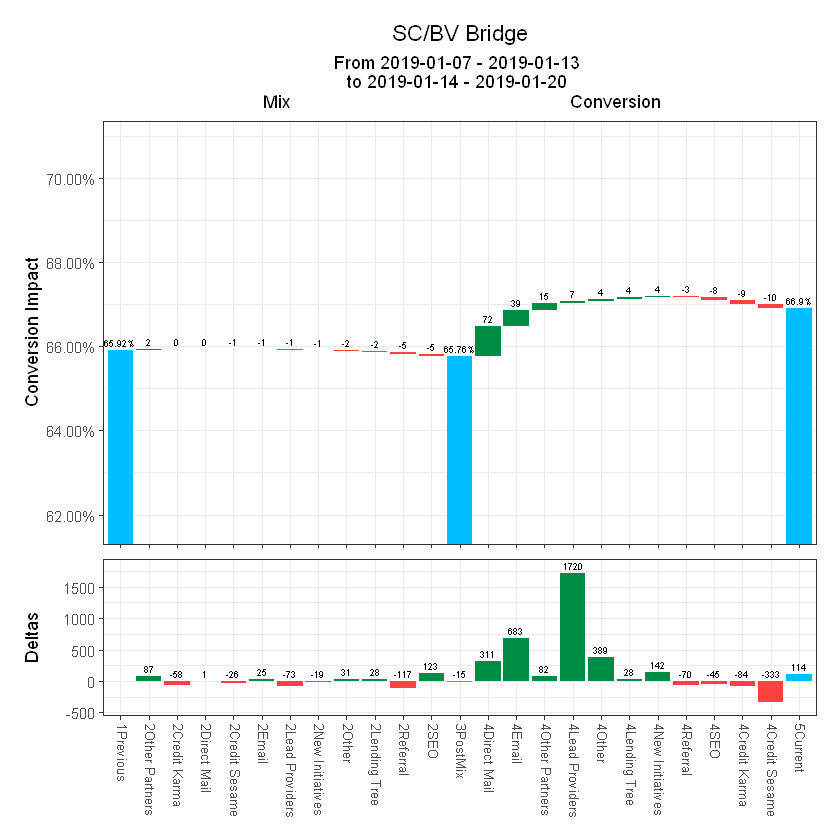

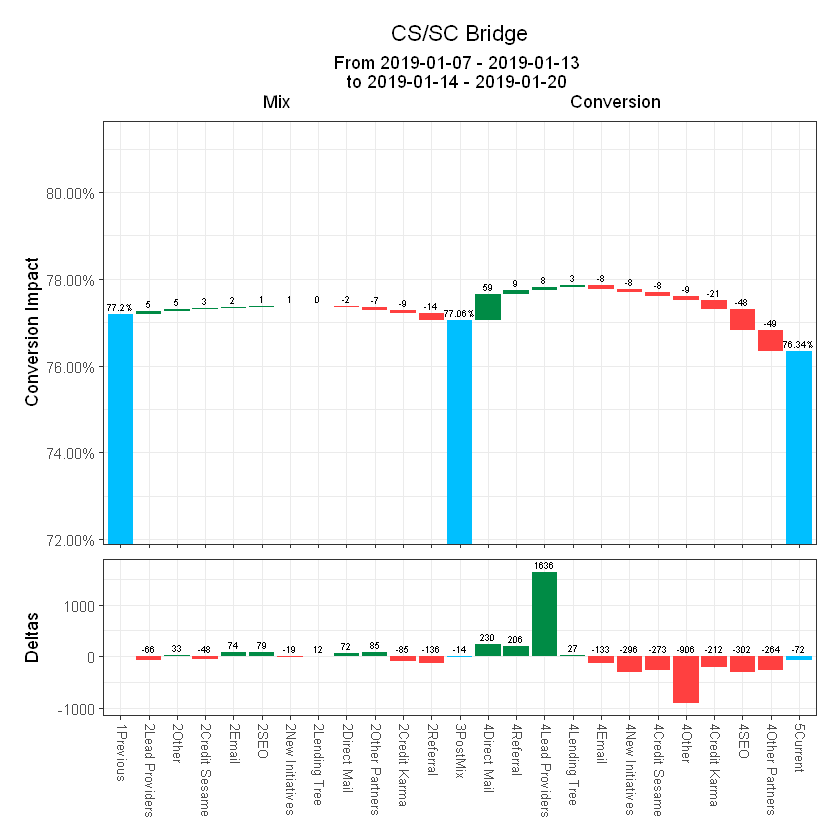

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


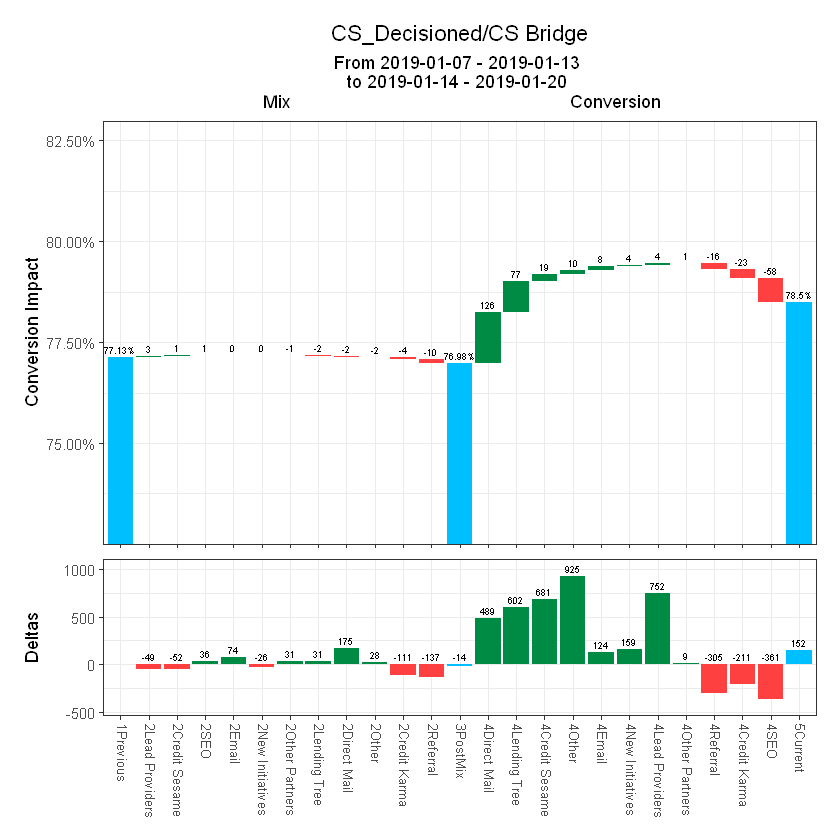

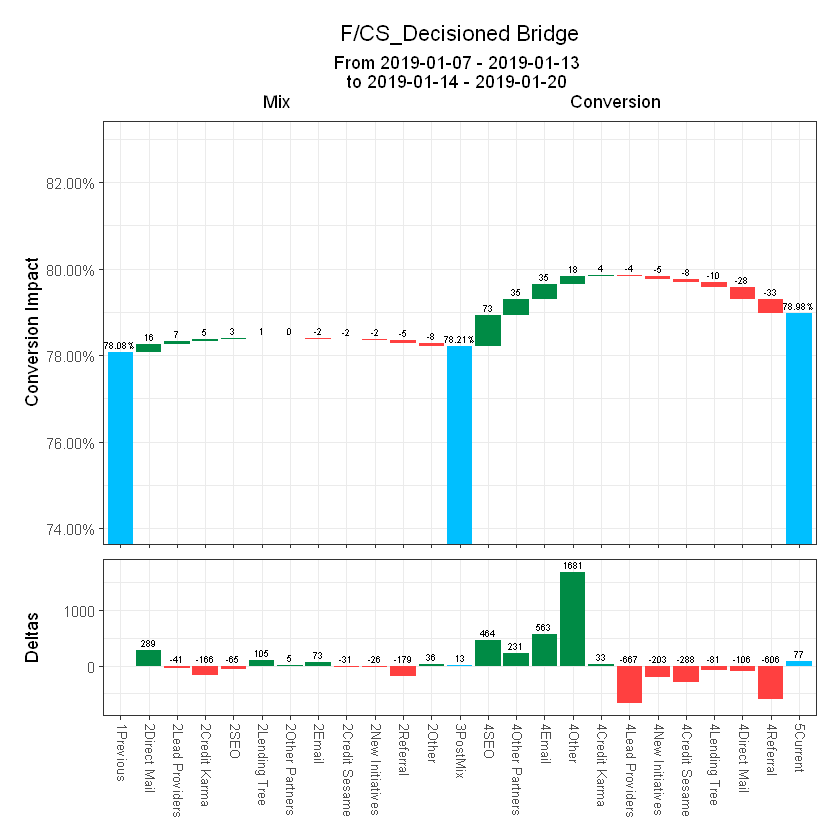

In [45]:
get_ggplot_all(snapshot = FALSE)

## Add blue bars to compare the conversion checkpoints!